# Simulating Myopic and Astigmatic Blur

The goal of this notebook is to numerically simulate myopic and astigmatic defocus while taking diffraction into account.

There were two previous "warm-up" notebooks that helped lay the groundwork necessary to solve this.
The first was a solving an easier blur simulation that used geometric optics in the notebook [Geometric_Optics_2_Defocus](./Geometric_Optics_2_Defocus.ipynb).
Generally in order to simulate blur, one needs to first define a blur kernel, then run that kernel over an image as 2D convolution.
For instance the following kernel would evenly spread out each pixel into its surrounding 3x3 square while keeping the average colors and intensities the same:

$$M = \begin{bmatrix} 1/9 & 1/9 & 1/9 \\ 1/9 & 1/9 & 1/9 \\ 1/9 & 1/9 & 1/9 \end{bmatrix}$$

Intuitively each row/column in the kernel corrsponds to the weight to apply each pixel in each direction (although technically in reverse).
To get a better understanding of blur kernels and 2D convolutions I'd highly recommend the convolution video series by 3blue1brown.

The second notebook was [Diffraction_3_Goodman_Ch4_Fresnel_Fraunhofer](./Diffraction_3_Goodman_Ch4_Fresnel_Fraunhofer.ipynb).
In that notebook I simulated arbitrary Fraunhofer Diffraction patterns using the 2D FFT algorithm in numpy.
At the time I was mainly curious to see what certain diffraction patterns looked like, but as it turns out understanding how to use the 2D FFT was critical to solving this problem, especially with understanding precisely all of the units involved.

The high-level strategy will be as follows. First we will solve how a point source in the object plane spreads out in the corresponding image plane, given the pupil diameter, wavelength of light, and amount of myopic/astigmatic refrative error. Second, we will put the solution of this "spreading out" into discrete units where each unit corresponds to 1 pixel in the image. Third, we will normalize this solution (sums to 1) and run it as a blur convolution over the image in order to simulate blur.

## Starting Equation

Recall the lens equation from [Diffraction Part 4](./Diffraction_4_Goodman_Ch5_Lenses.ipynb):

$$\begin{align}
\psi_i(x_o,y_o,x_i,y_i) &= \frac{\psi_0}{\lambda^2 z_o z_i} \exp{ \left[ \frac{ik}{2z_o} (x_o^2 + y_o^2) \right]} \exp{ \left[ \frac{ik}{2z_i} (x_i^2 + y_i^2) \right] } \times \\
& \iint_{-\infty}^{\infty} P(x_l', y_l') \exp{ \left[ \frac{ik}{2} \left( x_l'^2 + y_l'^2 \right) \left( -\frac{1}{f} + \frac{1}{z_o} + \frac{1}{z_i} \right) \right] } \exp{ \left\{ -ik \left[ \left( \frac{x_o}{z_o} + \frac{x_i}{z_i} \right) x_l' + \left( \frac{y_o}{z_o}+\frac{y_i}{z_i} \right)y_l' \right] \right\} }dx_l' dy_l'
\end{align}$$

This equation solves for the amplitude of light which begins at object coordinates $(x_o,y_o)$, passes through a lens, and ends at image coordinates $(x_i,y_i)$. The other variables represent the following. $\psi_0$ is the light amplitude at the source, $z_o$ and $z_i$ are the lens distances to the object and image respectively, $f$ is the focal length of the lens, $k$ and $\lambda$ are the wavenumber and wavelength of light respectively, $x_l'$ and $y_l'$ are integration coordinates over the lens, and $P(x_l',y_l')$ is the pupil function which is usually defined as $1$ inside a circular aperture and zero everywhere else.

## Defining Angles

Since this equation is in terms of distances, but defocus blur is in terms of angles, we re-write the equation using the object and image angles below. Note that we flip the coordinate system in the object plane. The reason is that the image is flipped physically, and the amplitude equation is more natural when the object and image coordinates are expressed as an offset from each other. Whether the minus sign is on the object or image coordinates is arbitrary, but placing them on the object causes the fourier expressions later on to nicely align with standard conventions.

$$\theta_{xo} = - \frac{x_o}{z_o} , \theta_{yo} = - \frac{y_o}{z_o}, \theta_{xi} = \frac{x_i}{z_i}, \theta_{yi} = \frac{y_i}{z_i}$$
$$\theta_o^2 = \theta_{xo}^2 + \theta_{yo}^2$$
$$\theta_i^2 = \theta_{xi}^2 + \theta_{yi}^2$$

We also group the factors of 1/2 with the squared terms to emphasize that these go together, since they were a result of making square root binomial approximations during the derivation. The equation becomes:

$$\begin{align}
\psi_i(\theta_{xo},\theta_{yo},\theta_{xi},\theta_{yi}) &= \frac{\psi_0}{\lambda^2 z_o z_i} \exp{ \left[ ik z_o \frac{\theta_o^2}{2} \right]} \exp{ \left[ ik z_i \frac{\theta_i^2}{2} \right] }\iint_{-\infty}^{\infty} P(x_l', y_l') \exp{ \left[ ik \left( \frac{x_l'^2 + y_l'^2}{2} \right) \left( -\frac{1}{f} + \frac{1}{z_o} + \frac{1}{z_i} \right) \right] } \exp{ \left\{ -ik \left[ \left( \theta_{xi} - \theta_{xo} \right) x_l' + \left( \theta_{yi} - \theta_{yo} \right)y_l' \right] \right\} }dx_l' dy_l'
\end{align}$$

## Defining Refractive Error

Myopic blur is a result of the first exponential term under the integral. The following relation holds when an image is in focus:

$$\left( -\frac{1}{f} + \frac{1}{z_o} + \frac{1}{z_i} \right) = 0$$

When this term is not zero, the result is a blurring effect caused by the $x_l'^2 + y_l'^2$ term. Recall the definition of Lens Power from the notebook [Geometric Optics 2](Geometric_Optics_2_Defocus.ipynb). Lens Power has units of inverse meters or Diopters:

$$P = \frac{1}{f}$$

To be more precise, let us define $P_0$ as the lens power that would be needed for an image to be in focus, and $P$ as the actual lens power. The expression for an in-focus image becomes:

$$\left( -P_0 + \frac{1}{z_o} + \frac{1}{z_i} \right) = 0$$

Now suppose that the actual lens power does not correctly align the object and image distances, and is off by a factor of $\Delta P$:

$$P = P_0 + \Delta P$$

The in-focus relation allows us to write this expression:

$$\left[ -\left( P - \Delta P \right) + \frac{1}{z_o} + \frac{1}{z_i} \right] = 0$$

This allows us to re-write the parentheses term as an equivalent amount of refractive error:

$$\Delta P = - \left( -\frac{1}{f} + \frac{1}{z_o} + \frac{1}{z_i} \right)$$

The amplitude equation becomes:

$$\begin{align}
\psi_i(\theta_{xo},\theta_{yo},\theta_{xi},\theta_{yi}) &= \frac{\psi_0}{\lambda^2 z_o z_i} \exp{ \left[ ik z_o \frac{\theta_o^2}{2} \right]} \exp{ \left[ ik z_i \frac{\theta_i^2}{2} \right] }\iint_{-\infty}^{\infty} P(x_l', y_l') \exp{ \left\{ - ik \left[ \left( \frac{x_l'^2 + y_l'^2}{2} \right) \Delta P + \left( \theta_{xi} - \theta_{xo} \right) x_l' + \left( \theta_{yi} - \theta_{yo} \right)y_l' \right] \right\}  } dx_l' dy_l'
\end{align}$$

Writing it this way will allows us to simulate particular amounts of myopia. For instance, if we were interested in simulating a quarter-diopter of myopic blur, we can set $\Delta P=0.25$, as this would be equivalent to a cornea that is too convex by 0.25D.

## Defining Intensity

An image is given by the intensity of light at each location, which ignores its underlying phase. The intensity is given by the squared absolute value of the amplitude, or equivalently the amplitude times its complex conjugate:

$$I = \big|\psi_i\big|^2 = (\psi_i) \times (\psi_i)^{*}$$

Assuming incoherent light from really far away it should be safe to drop both phase terms outside the integral. First let's understand where these terms are coming from. Essentially as light travels a distance $d$ its phase rotates by a factor of $e^{ikd}$. The amplitude equation actually had factors of $e^{ikz_o}$ and $e^{ikz_i}$ that were dropped in part 4 due to effectively being constant phase offsets. The $\theta_o^2$ and $\theta_i^2$ terms are similar in that they result from the separation from the z-axis under the small angle approximation, and were kept around just in case.

To better understand this problem, let's imagine a photon detector at image coordinates $(x_i,y_i)$, such as a CCD pixel or retinal cell. This detector will not care about the phase offset introduced by being placed a distance $\sqrt{x_i^2+y_i^2}$ away from the z-axis, as this is essentially just another constant phase offset similar to $e^{ikz_i}$. However, this detector is looking out at many objects in its field of view. If the detector is looking at object sources that are closely spaced together, and their illumination is somewhat coherent, their phase terms may still interfere with each other. But if the object light is incoherent, then their phase terms will no longer have any correlation, in which case the total intensity will be given by adding up each object's intensity separately. It's important to keep this assumption of incoherence in mind, as there could be situations where objects are closely spaced together and illuminated coherently, in which case a full integral with phase terms would need to be solved for that situation specifically:

$$I(\theta_{xi}, \theta_{yi}) = \Bigg| \iint \psi_i(\theta_{xo}, \theta_{yo}, \theta_{xi}, \theta_{yi}) dx_o dy_o \Bigg|^2$$

It's worth noting that Goodman has a long discussion in the book about whether the object phase can be dropped. In the book he mentions that in most situations the variation in phase over object angles is small enough that this term is effectively constant over its region in image space. However in the case of distance vision we can see this is not the case, since the phase variation over two [retina cells](https://en.wikipedia.org/wiki/Visual_acuity#Physiology) at the distance to a [Snellen Chart](https://en.wikipedia.org/wiki/Snellen_chart) is given by the [following](https://www.wolframalpha.com/input?i=%282+*+pi+%2F+500e-9%29+*+6+*+%281+arc-minute+to+radian%29%5E2+%2F+2):

$$\begin{align}
\theta_o &\approx 1 \mbox{ arc-minute} \\
\lambda &\approx 500 \cdot 10^{-9} m^{-1}\\
z_o &\approx 20 \mbox{ ft} \\
\frac{(k z_o) \theta_o^2}{2} &\approx 3.2 \mbox{ rad}
\end{align}$$

Intuitively we can see why this term matters for a high enough distance. The integral is only affected by $\theta_o$, whereas the outside phase term depends on both $\theta_o$ and $z_o$. Therefore if $\theta_o$ is fixed, no matter how small it is there must always be a large enough distance $z_o$ at which this phase begins to change by a significant factor. We're still going to drop this term, but we should keep in mind that it's because of the assumption of incoherent light, rather than the assumption of small phase variation in the object plane with coherent light.

Finally, because we will normalize the blur kernel later, we don't care about the absolute intensities, only the relative intensities. We will go into the convolution details later, but for now we can define the following to help simplify the equation further:

$$I_0 = \left| \frac{\psi_0}{\lambda^2 z_o z_i} \right|^2$$

The equation becomes

$$I(\theta_{xo},\theta_{yo},\theta_{xi},\theta_{yi}) = I_0 \Bigg| \iint_{-\infty}^{\infty} P(x_l', y_l') \exp{ \left\{ - i k \left[ \frac{\Delta P}{2} \left( x_l'^2 + y_l'^2 \right) + \left( \theta_{xi} - \theta_{xo} \right) x_l' + \left( \theta_{yi} - \theta_{yo} \right)y_l' \right] \right\} } dx_l' dy_l' \Bigg|^2$$

## Reframing as Angle Differences

Now that we've removed the outside phase terms, the function above only depends the differences in the angles $\left(\theta_{xi}-\theta_{xo}\right)$ and $\left(\theta_{yi}-\theta_{yo}\right)$, rather than the angles themselves. This means we can reframe the integral in terms of angle offsets:

$$\begin{align}
\alpha_x &= \theta_{xi} - \theta_{xo} \\
\alpha_y &= \theta_{yi} - \theta_{yo}
\end{align}$$

$$I(\alpha_x, \alpha_y) = I_0 \Bigg| \iint_{-\infty}^{\infty} P(x_l', y_l') \exp{ \left\{ - i k \left[ \Delta P \left( \frac{x_l'^2 + y_l'^2}{2} \right) + \alpha_x x_l' +  \alpha_y y_l' \right] \right\} } dx_l' dy_l' \Bigg|^2$$

Because the integral above gives the image spread from an object point source, if we were to solve the integral numerically, we could then map the result over an image and sum the results to simulate the resulting overall blur from each point, giving us our blur kernel for the convolution.

## Defining the Fourier Transform

It's worth noting that this integral is actually a [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform). Recall the definition of the 2D Fourier Transform:

$$\hat{f}(\nu_x, \nu_y) = \mathcal{F} \big[ f \big] = \iint_{-\infty}^\infty f(x,y) \exp {\left[ - 2 \pi i \left( \nu_x x + \nu_y y \right) \right] }dx $$

Setting $k=2 \pi / \lambda$ we have:

$$I(\alpha_x, \alpha_y) = I_0 \Bigg| \iint_{-\infty}^{\infty} P(x_l', y_l') \exp{ \left\{ - 2 \pi i \left[ \frac{\Delta P}{\lambda} \left( \frac{x_l'^2 + y_l'^2}{2} \right) \right] \right\} } \exp { \left\{ - 2 \pi i \left[ \left( \frac{\alpha_x}{\lambda} \right) x_l' + \left( \frac{\alpha_y}{\lambda} \right) y_l' \right] \right\} } dx_l' dy_l' \Bigg|^2$$

This means that $I$ is given by the 2D Fourier Transform of everything between the integral and the second exponential term. This may look more abstract and difficult, but it actually makes our life easier, as now we can calculate this function numerically by plugging it straight into numpy's 2D FFT. We just have to be somewhat careful in keeping track of the units.

$$\hat{f}(\nu_x,\nu_y) = \mathcal{F} \left[ P(x_l', y_l') \exp{ \left\{ - 2 \pi i \left( \frac{\Delta P}{\lambda} \right) \left( \frac{x_l'^2 + y_l'^2}{2} \right) \right\} } \right]$$

$$I(\alpha_x, \alpha_y) = I_0 \Big| \hat{f} \left( \nu_x=\frac{\alpha_x}{\lambda}, \nu_y=\frac{\alpha_y}{\lambda} \right) \Big|^2$$

The units are a bit tricky, which to help understand I did some prior derivations in the [Diffraction Part 3 notebook](./Diffraction_3_Goodman_Ch4_Fresnel_Fraunhofer.ipynb). Basically the function that we input to the Fourier Transform won't actually run from $-\infty$ to $\infty$ but rather have some finite range $L$. The function will also have some finite number of samples $N$. Running the discrete FFT on this finite function returns a grid with the following angular bin sizes and total angular FOV:

$$\Delta \alpha = \frac{\lambda}{L}$$
$$\alpha_\mbox{max} \approx \frac{N \lambda}{2L}$$

To be clever, we can choose $L$ such that $\Delta \alpha$ is equal to one pixel, which essentially gives us the blur kernel on a silver platter, though it still needs to be normalized. We just need to make $N$ to large enough that the intensity has mostly dropped off to zero around the kernel's edge.

## Adding Astigmatism

The derivation for cylindrical blur is exactly the same as for spherical blur, except instead of the squared distance to the center of the lens $x_l'^2+y_l'^2$ we have the squared distance to the astigmatism axis $d_l'^2$. For a vertical axis this would be $x_l'^2$, and for a horizontal axis this would be $y_l'^2$. More generally, for a blur direction at angle $\beta$ the distance would be $d_l' = \rho_l' \cos(\phi_l'-\beta)$, where $\rho_l'$ and $\phi_l'$ are the lens variables in polar coordinates.

Note that for a glasses prescription with cyl axis $\gamma$, the blur direction is $\beta = \frac{\pi}{2} - \gamma$. This is for two reasons. First, the cyl angle is relative to the eye doctor and not the patient, so need to flip it horizontally $\pi - \beta$ to get the angle from the patient's perspective. Second, the glasses cyl axis is the angle around which the lens is curved, not the direction of blur, so we need to subtract $\pi/2$ to get the blur direction.

The final equation becomes:

$$I(\alpha_x, \alpha_y) = I_0 \Bigg| \iint_{-\infty}^{\infty} P(x_l', y_l') \exp{ \left\{ - 2 \pi i \left[ \frac{\Delta P_{\mbox{(sph)}}}{\lambda} \left(\frac{x_l'^2 + y_l'^2}{2} \right) \right] \right\} } \exp { \left\{ -2 \pi i \left[ \frac{\Delta P_{\mbox{(cyl)}}}{\lambda} \left( \frac{d_l'^2}{2} \right) \right] \right\} } \exp { \left\{  - 2 \pi i \left[ \left( \frac{\alpha_x}{\lambda} \right) x_l' + \left( \frac{\alpha_y}{\lambda} \right) y_l' \right] \right\} } dx_l' dy_l' \Bigg|^2$$

## Understanding The Code

We now have all the mathematical pieces necessary to simulate blur on a Snellen chart. First we download a Snellen picture off the internet. We then open the picture and zoom in on the 20/20 line to see how many pixels tall it is (I typically use GIMP for this). Since we know IRL the 20/20 line has a height of 5 arc-minutes, we can divide the 20/20 pixel height by 5 and multiply it by (radians/arc-minute) to get the angular width of each pixel in terms of radians. This is our desired value of $\Delta \alpha$ from the FFT.

We then compute $L = \lambda / \Delta \alpha$. This will be the bounding box for the function that will go into the FFT. We then pick a value for N, and instantiate a grid of values with size $L \times L$ having N values along each axis. We can pick a value for the eye's diameter (eg somewhere within 2-8mm), and set values in this grid to be 1 inside radius $d/2$ and 0 everywhere else to represent a circular aperture with diameter $d$. We then mutliply this function by the $x_l'^2+y_l'^2$ exponential term.

Next we plug this grid of values into numpy's 2D FFT algorithm. We then take the output, compute its element-wise squared absolute value, then normalize it. This new grid is the convolution blur kernel.

Finally we use opencv to run this blur kernel over the image to simulate our blur. If the simulation takes too long to run, we can make N smaller. If the numerical kernel doesn't cover enough of the true kernel we can make N larger.

Note that due to the time it takes to generate the kernels and each set of plots, these were separated into different jupyter notebook cells. The simulations below range sph and cyl from 0 to 1 in 0.25 increments and show the results in a 5x5 grid.

In [1]:
import numpy as np

# main parameters to change if you want to play around with this
d = .002 # pupil diameter, mm
cyl_ax_deg = 50
wavelength = 500e-9 # 500nm
sphs = [0, 0.25, 0.5, 0.75, 1]
cyls = [0, 0.25, 0.5, 0.75, 1]

# input number is the axis of rotation of the cylindrical lens
# blur direction is 90 degree offset
# minus sign comes from flipping doctor's perspective to patient's perspective
cyl_ax = cyl_ax_deg * (2*np.pi/360)
blur_angle = np.pi/2 - cyl_ax

rad2am = 360 / (2*np.pi) * 60
am2px = 200/5 # block_letter_eye_chart has 20/20 row that is 200px high
epsilon = 1e-8

L = wavelength * rad2am * am2px

N = 2000
min_v = -L/2
max_v = L/2
d_v = L / N

x,y = np.mgrid[min_v:(max_v+epsilon):d_v, min_v:(max_v+epsilon):d_v]

phi = np.arctan2(y,x)
cyl_dist = np.sqrt(x**2+y**2) * np.cos(phi-blur_angle)

def get_kernel(sph, cyl, cyl_ax):
    A = np.exp(-1j * 2 * np.pi * sph/(2 * wavelength) * (x**2+y**2) )
    A = np.multiply(A, np.exp(-1j * 2 * np.pi * cyl/(2 * wavelength) * cyl_dist**2 ))
    A[np.sqrt(x**2+y**2)>(d/2)] = 0j
    
    F = np.fft.fftshift(np.fft.fft2(A))
    I = np.abs(F)**2
    I = I / I.sum()

    return I

# cache the kernels here because they take a while
kernels = []
for sph in sphs:
    curr_kernels = []
    for cyl in cyls:
        curr_kernel = get_kernel(sph, cyl, cyl_ax)
        curr_kernels.append(curr_kernel)
    kernels.append(curr_kernels)

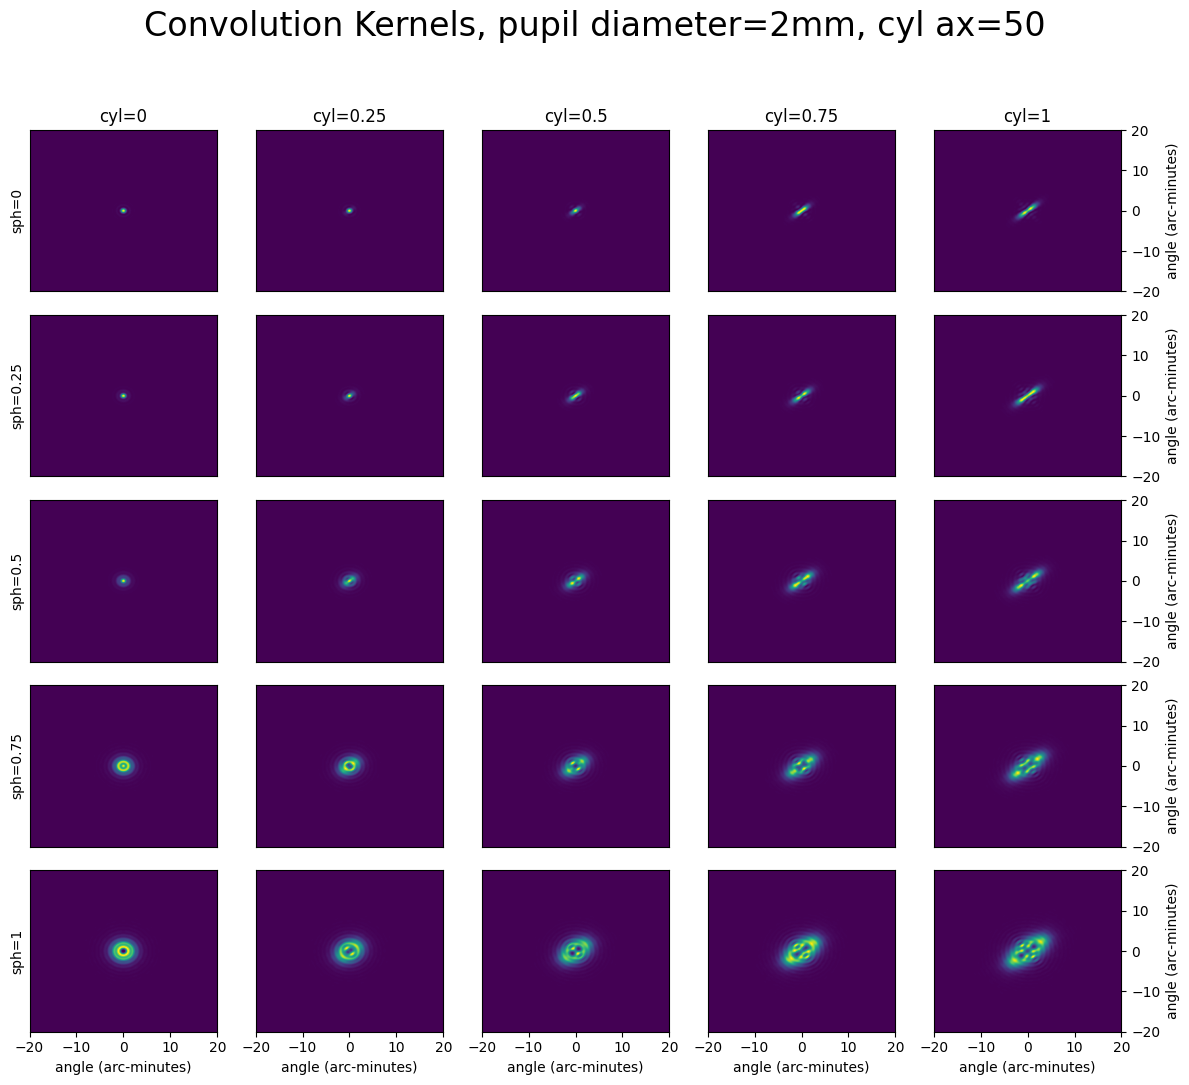

In [2]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import path

fig, axs = plt.subplots(len(sphs), len(cyls), figsize=(12, 12))

d_theta = wavelength / L
x_theta, y_theta = np.mgrid[-N/2:N/2+1:1, -N/2:N/2+1:1] * d_theta * (360/(2*np.pi)) * 60

max_plot_angle = 20 # arc-minutes

for i,sph in enumerate(sphs):
    for j,cyl in enumerate(cyls):
        I = kernels[i][j]
        ax_I = axs[i][j]
        im_I = ax_I.pcolormesh(x_theta, y_theta, I)
        ax_I.set_xlim(-max_plot_angle, max_plot_angle)
        ax_I.set_ylim(-max_plot_angle, max_plot_angle)
        if(i<len(sphs)-1):
            ax_I.set_xticks([])
        else:
            ax_I.set_xlabel('angle (arc-minutes)')
        if(j<len(cyls)-1):
            ax_I.set_yticks([])
        else:
            ax_I.yaxis.tick_right()
            ax_I.yaxis.set_label_position('right')
            ax_I.set_ylabel('angle (arc-minutes)')
        if(i==0):
            ax_I.set_title(f'cyl={cyl}')
        if(j==0):
            ax_I.set_ylabel(f'sph={sph}')

fig.tight_layout()
# https://stackoverflow.com/questions/8248467/tight-layout-doesnt-take-into-account-figure-suptitle
plt.subplots_adjust(top=0.8)
plt.suptitle(f'Convolution Kernels, pupil diameter={int(d*1000)}mm, cyl ax={cyl_ax_deg}', y=.9, fontsize=24)
plt.savefig('images/diffraction_kernels.png', dpi=400)
plt.show()

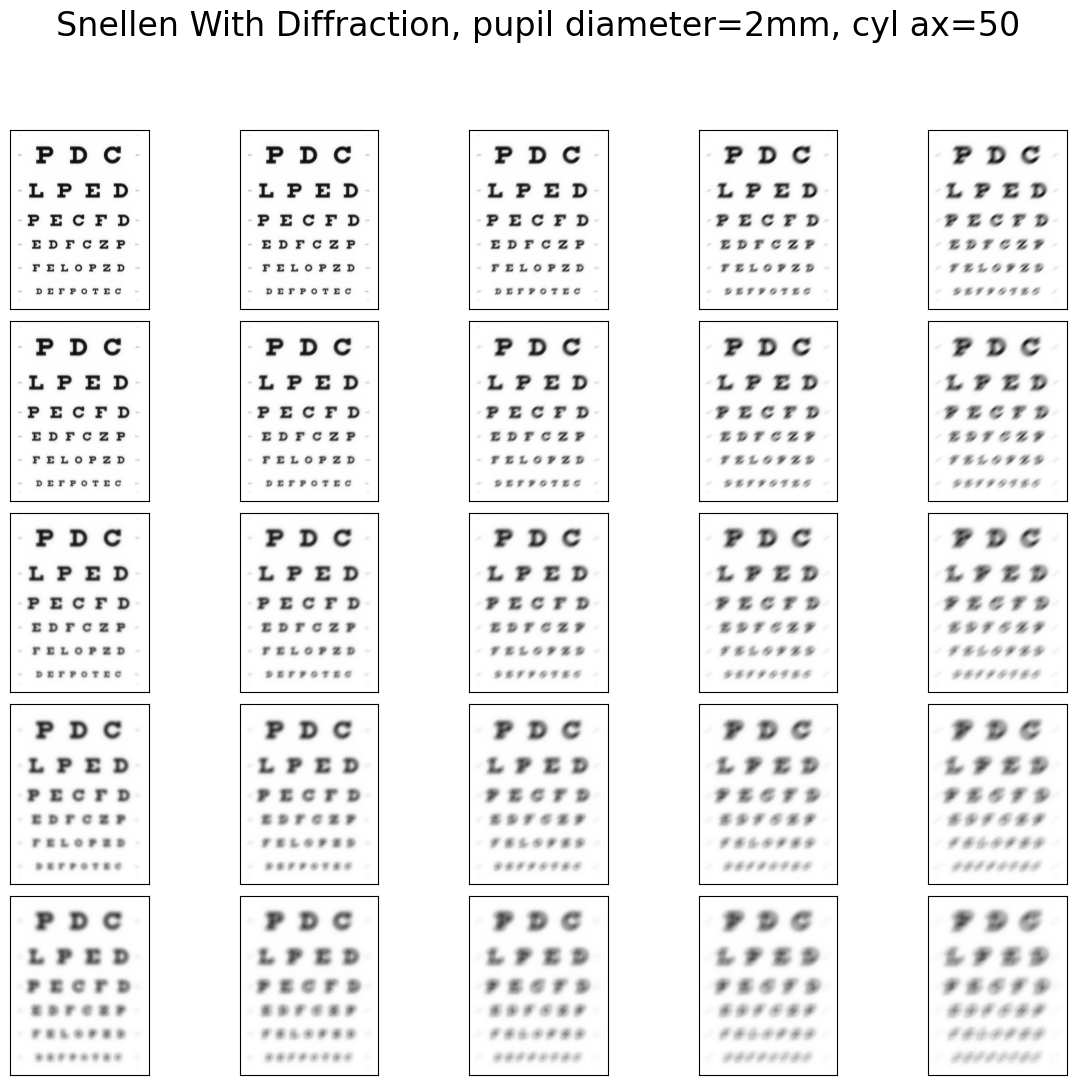

In [3]:
import cv2

img = cv2.imread('images/block_letter_eye_chart.png')

fig, axs = plt.subplots(len(sphs), len(cyls), figsize=(12, 12))

for i,sph in enumerate(sphs):
    for j,cyl in enumerate(cyls):
        kernel = kernels[i][j].T
        ax = axs[i][j]
        dst = cv2.filter2D(img,-1,kernel[:, ::-1])
        ax.imshow(dst)
        ax.set_xticks([])
        ax.set_yticks([])
        if(i==0):
            ax_I.set_title(f'cyl={cyl}')
        if(j==0):
            ax_I.set_ylabel(f'sph={sph}')

fig.tight_layout()
# https://stackoverflow.com/questions/8248467/tight-layout-doesnt-take-into-account-figure-suptitle
plt.subplots_adjust(top=0.8)
plt.suptitle(f'Snellen With Diffraction, pupil diameter={int(d*1000)}mm, cyl ax={cyl_ax_deg}', y=.9, fontsize=24)
plt.savefig('images/diffraction_snellens.png', dpi=400)
plt.show()